In [114]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import os
from datetime import datetime
import itertools

### Loading Price Data

In [ ]:
project_root = os.path.abspath(os.getcwd())

data_dir = os.path.join(project_root, '..', '..', 'data')

# Summer month

p_summer = pd.read_csv(os.path.join(data_dir, 'Spotmarket_August_Corrected.csv'),sep=',')
#change price from euro/mwh to euro/kwh and renaming the column
p_summer['price_EUR_MWh'] = p_summer['price_EUR_MWh'] / 1000
p_summer.rename(columns={'price_EUR_MWh': 'Spotmarket_(EUR/kWh)'}, inplace=True)

# Winter month

p_winter = pd.read_csv(os.path.join(data_dir, 'Spotmarket_December_Corrected.csv'),sep=',')
#change price from euro/mwh to euro/kwh and renaming the column
p_winter['price_EUR_MWh'] = p_winter['price_EUR_MWh'] / 1000
p_winter.rename(columns={'price_EUR_MWh': 'Spotmarket_(EUR/kWh)'}, inplace=True)



#Spotmarket data from: https://energy-charts.info/charts/price_spot_market/chart.htm?l=en&c=CH&interval=month&year=2024&legendItems=by4&month=12


### Loading Fixed Appliances Data

In [ ]:
#TV consumption data for summer month
tv_summer = pd.read_csv(os.path.join(data_dir, 'tv_consumption_august_2024_detailed.csv'), sep=',')

#TV consumption data for winter month
tv_winter = pd.read_csv(os.path.join(data_dir, 'tv_consumption_december_2024_detailed.csv'), sep=',')

#Lighting consumption data for summer month
lighting_summer = pd.read_csv(os.path.join(data_dir, 'lighting_consumption_august_2024.csv'), sep=',')

#Lighting consumption data for winter month
lighting_winter = pd.read_csv(os.path.join(data_dir, 'lighting_consumption_december_2024.csv'), sep=',')

#Fridge consumption data for summer month
fridge_summer = pd.read_csv(os.path.join(data_dir, 'fridge_August_Final_Adjusted.csv'), sep=',')

#Fridge consumption data for winter month
fridge_winter = pd.read_csv(os.path.join(data_dir, 'fridge_December_Final_Adjusted.csv'), sep=',')

#Oven consumption data for summer month
oven_summer = pd.read_csv(os.path.join(data_dir, 'Oven_Energy_Consumption_August_Final.csv'),sep=',')

#Oven consumption data for winter month
oven_winter = pd.read_csv(os.path.join(data_dir, 'Oven_Energy_Consumption_December_Final.csv'),sep=',')

#Induction stove consumption data for summer month
induction_summer = pd.read_csv(os.path.join(data_dir, 'Induction_Stove_Energy_Consumption_August_Final.csv'),sep=',')

#Induction stove consumption data for winter month
induction_winter = pd.read_csv(os.path.join(data_dir, 'Induction_Stove_Energy_Consumption_December_Final.csv'),sep=',')

#adjust names of columns for summer
tv_summer.columns = tv_summer.columns.str.replace('tv_power_kWh', 'TV_Consumption_(kWh)')
lighting_summer.columns = lighting_summer.columns.str.replace('lighting_power_kWh', 'Lighting_Consumption_(kWh)')
fridge_summer.columns = fridge_summer.columns.str.replace('consumption_kWh', 'Fridges_Consumption_(kWh)')
oven_summer.columns = oven_summer.columns.str.replace('consumption_kWh', 'Oven_Consumption_(kWh)')
induction_summer.columns = induction_summer.columns.str.replace('consumption_kWh', 'Induction_Stove_Consumption_(kWh)')

#adjust names of columns for winter
tv_winter.columns = tv_winter.columns.str.replace('tv_power_kWh', 'TV_Consumption_(kWh)')
lighting_winter.columns = lighting_winter.columns.str.replace('lighting_power_kWh', 'Lighting_Consumption_(kWh)')
fridge_winter.columns = fridge_winter.columns.str.replace('consumption_kWh', 'Fridges_Consumption_(kWh)')
oven_winter.columns = oven_winter.columns.str.replace('consumption_kWh', 'Oven_Consumption_(kWh)')
induction_winter.columns = induction_winter.columns.str.replace('consumption_kWh', 'Induction_Stove_Consumption_(kWh)')


### Building Database

In [117]:
# Ensure all timestamp columns are of the same type for summer
p_summer['timestamp'] = pd.to_datetime(p_summer['timestamp'])
lighting_summer['timestamp'] = pd.to_datetime(lighting_summer['timestamp'])
fridge_summer['timestamp'] = pd.to_datetime(fridge_summer['timestamp'])
oven_summer['timestamp'] = pd.to_datetime(oven_summer['timestamp'])
induction_summer['timestamp'] = pd.to_datetime(induction_summer['timestamp'])
tv_summer['timestamp'] = pd.to_datetime(tv_summer['timestamp'])

# Ensure all timestamp columns are of the same type for winter
p_winter['timestamp'] = pd.to_datetime(p_winter['timestamp'])
lighting_winter['timestamp'] = pd.to_datetime(lighting_winter['timestamp'])
fridge_winter['timestamp'] = pd.to_datetime(fridge_winter['timestamp'])
oven_winter['timestamp'] = pd.to_datetime(oven_winter['timestamp'])
induction_winter['timestamp'] = pd.to_datetime(induction_winter['timestamp'])
tv_winter['timestamp'] = pd.to_datetime(tv_winter['timestamp'])


#shorten the dataset to 4 weeks (4 weeks * 7 days * 24 hours = 672 rows) for summer
lighting_summer = lighting_summer.iloc[:4 * 7 * 24]
fridge_summer = fridge_summer.iloc[:4 * 7 * 24]
oven_summer = oven_summer.iloc[:4 * 7 * 24]
induction_summer = induction_summer.iloc[:4 * 7 * 24]
tv_summer = tv_summer.iloc[:4 * 7 * 24]
p_summer = p_summer.iloc[:4 * 7 * 24]

#shorten the dataset to 4 weeks (4 weeks * 7 days * 24 hours = 672 rows) for winter
lighting_winter = lighting_winter.iloc[:4 * 7 * 24]
fridge_winter = fridge_winter.iloc[:4 * 7 * 24]
oven_winter = oven_winter.iloc[:4 * 7 * 24]
induction_winter = induction_winter.iloc[:4 * 7 * 24]
tv_winter = tv_winter.iloc[:4 * 7 * 24]
p_winter = p_winter.iloc[:4 * 7 * 24]


# Merge all datasets on the 'timestamp' column for summer
merged_data_summer = p_summer.merge(lighting_summer, left_on='timestamp', right_on='timestamp', how='outer') \
    .merge(oven_summer, left_on='timestamp', right_on='timestamp', how='outer') \
        .merge(tv_summer, left_on='timestamp', right_on='timestamp', how='inner')\
            .merge(induction_summer, left_on='timestamp', right_on='timestamp', how='inner') \
                .merge(fridge_summer, left_on='timestamp', right_on='timestamp', how='inner') \

#Merge all datasets on the 'timestamp' column for winter
merged_data_winter = p_winter.merge(lighting_winter, left_on='timestamp', right_on='timestamp', how='outer') \
    .merge(oven_winter, left_on='timestamp', right_on='timestamp', how='outer') \
        .merge(tv_winter, left_on='timestamp', right_on='timestamp', how='inner')\
            .merge(induction_winter, left_on='timestamp', right_on='timestamp', how='inner') \
                .merge(fridge_winter, left_on='timestamp', right_on='timestamp', how='inner') \
                    

# Display the merged dataset
#print(merged_data_summer)
#print(merged_data_winter)

### Dishwasher

In [ ]:
# Load data
price = merged_data_summer["Spotmarket_(EUR/kWh)"].values
fridge = merged_data_summer["Fridges_Consumption_(kWh)"].values
stove = merged_data_summer["Induction_Stove_Consumption_(kWh)"].values
oven = merged_data_summer["Oven_Consumption_(kWh)"].values
tv = merged_data_summer["TV_Consumption_(kWh)"].values
lighting = merged_data_summer["Lighting_Consumption_(kWh)"].values

Time_interval = len(price)  # Total time interval in hours

# Dishwasher properties
duration = 3  # hours of operation
min_gap = 15  # hours between runs
power_dishwasher = 1.5  # kW during operation

# Gurobi model
model = gp.Model("automated_demand_response")

# Binary start variables: 1 if dishwasher starts at hour t
start_times = range(Time_interval - duration + 1)
dishwasher_start = model.addVars(start_times, vtype=GRB.BINARY, name="start")

# Binary on variables: 1 if dishwasher is on at hour t
binary_dishwasher = model.addVars(Time_interval, vtype=GRB.BINARY, name="on")

for t, k in itertools.product(range(len(start_times)), range(duration)):
    model.addConstr(binary_dishwasher[t + k] >= dishwasher_start[t], name=f"dishwasher_{t}_{k}")

for t in range(len(start_times)-1):
    model.addConstr(gp.quicksum(binary_dishwasher[t + k] for k in range(duration+1)) <= 3, name=f"max_three_hours_on_{t}")


# Enforce min 1 run per day
#adds up all possible start times of the dishwasher in a single and '>= 1' day ensures that the dishwasher has to run once per day
hours_per_day = 24
days = Time_interval // hours_per_day
for d in range(days-1):
    model.addConstr(gp.quicksum(dishwasher_start[t] for t in range(d * 24, (d + 1) * 24)) == 1,
                name=f"max_one_run_per_day_dishwasher_{d}")
    
# Enforce max 1 run per day of max 3 hours
#adds up all possible start times of the dishwasher in a single and '<= 1' day ensures that the dishwasher doesn't run more than once per day
hours_per_day = 24
days = Time_interval // hours_per_day
for d in range(days-1):
    model.addConstr(gp.quicksum(binary_dishwasher[t] for t in range(d * 24, (d + 1) * 24)) == 3,
                name=f"max_one_run_per_day_dishwasher_{d}")

# Enforce minimum gap (15 hours) between two starts
#multiplying with min_gap so we don't constrain the dishwasher to start at the same time every day
#this enures that the optimizer can iterate through without being constrained to a single time
for t in range(len(start_times)-min_gap):
    model.addConstr(gp.quicksum(dishwasher_start[t + offset] for offset in range(1, min_gap + 1)) <= (1 - dishwasher_start[t]) * min_gap,
                name=f"min_gap_after_{t}")
    
#print(len(fridge))
#print(len(stove))
#print(len(tv))
#print(len(lighting))
#print(len(price))
#print(len(dishwasher_start))
#print(len(binary_dishwasher))
#print(len(start_times))



### Washing Machine

In [119]:
model.update()
### including the washing machine
# washing_machine properties
duration_wm = 2  # hours of operation
min_gap_wm = 1  # hours between runs
power_wm = 3  # kW during operation -> should be double checked
wm_runs_per_week = 4

binary_wm = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_wm")

# Binary start variables: 1 if washing machine starts at hour t

start_times_wm = range(Time_interval - duration_wm + 1)
wm_start = model.addVars(start_times_wm, vtype=GRB.BINARY, name="start_wm")

# Binary on variables: 1 if dishwasher is on at hour t

binary_wm = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_wm")

# When washing machine is on, it must be running -> wm_start is 1 -> binary_wm at the same time + duration_wm is 1 

for t, k in itertools.product(range(len(start_times_wm)), range(duration_wm)):
    model.addConstr(binary_wm[t + k] >= wm_start[t], name=f"wm_{t}_{k}")

for t in range(len(start_times_wm)-duration_wm):
    model.addConstr(gp.quicksum(binary_wm[t + k] for k in range(duration_wm+1)) <= duration_wm, name=f"wm_max_two_hours_on_{t}")


# Enforce min 4 runs per week -> if negative prices, can run more than 4 times, for now: exactly 4 times
#adds up all possible start times of the dishwasher in a single and '>= 1' day ensures that the washing machine has to run twice per week

hours_per_week = 24*7
weeks = Time_interval // hours_per_week
for week in range(weeks-1):
    model.addConstr(gp.quicksum(wm_start[t] for t in range(week * 24 * 7, (week + 1) * 24 * 7)) == wm_runs_per_week,
                name=f"wm_four_runs_per_week_{week}")


# Enforce minimum gap (1 hour) between two starts

for t in range(len(start_times_wm)-min_gap_wm):
    model.addConstr(gp.quicksum(wm_start[t + offset] for offset in range(1, min_gap_wm + 1)) <= (1 - wm_start[t]) * min_gap_wm,
                name=f"min_gap_after_washing_wm_{t}")
    
#washing machine can only run during certain hours of the day, during the week after 4pm and on weekends after 10am
# Add a new column to the dataframe indicating when the washing machine can be turned on
p_summer['Allowed_WM_summer'] = 0  # Initialize with 0
p_winter['Allowed_WM_winter'] = 0  # Initialize with 0

# Define the conditions for weekdays and weekends -> for summer and winter
for index, row in p_summer.iterrows():
    hour = row['timestamp'].hour
    day_of_week = row['timestamp'].weekday()  # Monday=0, Sunday=6
    if (day_of_week < 5 and 16 <= hour < 20) or (day_of_week >= 5 and 8 <= hour < 20):
        p_summer.at[index, 'Allowed_WM_summer'] = 1
    else: 
        p_summer.at[index, 'Allowed_WM_summer'] = 0


for index, row in p_winter.iterrows():
    hour = row['timestamp'].hour
    day_of_week = row['timestamp'].weekday()  # Monday=0, Sunday=6
    if (day_of_week < 5 and 16 <= hour < 20) or (day_of_week >= 5 and 8 <= hour < 20):
        p_winter.at[index, 'Allowed_WM_winter'] = 1
    else: 
        p_winter.at[index, 'Allowed_WM_winter'] = 0
        
model.addConstrs((binary_wm[t] <= p_summer['Allowed_WM_summer'][t] for t in range(len(binary_wm))), name="allowed_wm_summer")
#model.addConstrs((binary_wm[t] <= p_winter['Allowed_WM_winter'][t] for t in range(len(binary_wm))), name="allowed_wm_winter") #implement later




{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>

### EVs

### Objective Function and Optimization

In [120]:

# Total power consumption including fixed and dishwasher
total_load = [fridge[t] + stove[t] + tv[t] + lighting[t] + oven[t] + power_dishwasher * binary_dishwasher[t] + power_wm * binary_wm[t] for t in range(0,670)]

# Objective: minimize total electricity cost
model.setObjective(gp.quicksum(price[t] * total_load[t] for t in range(670)), GRB.MINIMIZE)

# Optimize
model.optimize()

### careful, will have to sync the time because the last week is sometimes omitted and not necessarily a full week so maybe will have to optimize over 5 weeks instead


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 21.6.0 21H1320)

CPU model: Intel(R) Core(TM) i5-6267U CPU @ 2.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 6731 rows, 3352 columns and 25427 nonzeros
Model fingerprint: 0xc877dc1d
Variable types: 0 continuous, 3352 integer (3352 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [3e-02, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]


Presolve removed 5602 rows and 2103 columns
Presolve time: 0.13s
Presolved: 1129 rows, 1249 columns, 10050 nonzeros
Variable types: 0 continuous, 1249 integer (1249 binary)
Found heuristic solution: objective 61049.475975

Root relaxation: objective 5.728190e+04, 246 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    57281.895975 57281.8960  0.00%     -    0s

Explored 1 nodes (246 simplex iterations) in 0.18 seconds (0.07 work units)
Thread count was 4 (of 4 available processors)

Solution count 2: 57281.9 61049.5 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.728189597469e+04, best bound 5.728189597469e+04, gap 0.0000%


### Debugging

In [121]:
#debugging washing machine
wm_starts_list = []
# Output washing machine schedule
if model.status == GRB.OPTIMAL:
    print(f"Total cost: {model.ObjVal:.2f}")
    for t in range(Time_interval-duration_wm+1):
        if wm_start[t].X > 0.5:
            print(f"Washing machine starts at: {p_summer['timestamp'][t]}")
            wm_starts_list.append(p_summer['timestamp'][t])


print("Washing machine schedule:")
print(wm_starts_list)

Total cost: 57281.90
Washing machine starts at: 2024-08-03 12:00:00
Washing machine starts at: 2024-08-04 08:00:00
Washing machine starts at: 2024-08-04 11:00:00
Washing machine starts at: 2024-08-04 14:00:00
Washing machine starts at: 2024-08-10 09:00:00
Washing machine starts at: 2024-08-10 12:00:00
Washing machine starts at: 2024-08-11 09:00:00
Washing machine starts at: 2024-08-11 12:00:00
Washing machine schedule:
[Timestamp('2024-08-03 12:00:00'), Timestamp('2024-08-04 08:00:00'), Timestamp('2024-08-04 11:00:00'), Timestamp('2024-08-04 14:00:00'), Timestamp('2024-08-10 09:00:00'), Timestamp('2024-08-10 12:00:00'), Timestamp('2024-08-11 09:00:00'), Timestamp('2024-08-11 12:00:00')]


In [122]:
#print timestamp and the corresponding state of the dishwasher
if model.status == GRB.OPTIMAL:
    for t in range(Time_interval):
        if binary_wm[t].X > 0.5:
            print(f"Washing Machine is ON at: {p_summer['timestamp'][t]}")
        else:
            print(f"Washing Machine is OFF at: {p_summer['timestamp'][t]}")
else:
    print("Model has not been solved to optimality. Unable to retrieve variable values.")

Washing Machine is OFF at: 2024-08-01 00:00:00
Washing Machine is OFF at: 2024-08-01 01:00:00
Washing Machine is OFF at: 2024-08-01 02:00:00
Washing Machine is OFF at: 2024-08-01 03:00:00
Washing Machine is OFF at: 2024-08-01 04:00:00
Washing Machine is OFF at: 2024-08-01 05:00:00
Washing Machine is OFF at: 2024-08-01 06:00:00
Washing Machine is OFF at: 2024-08-01 07:00:00
Washing Machine is OFF at: 2024-08-01 08:00:00
Washing Machine is OFF at: 2024-08-01 09:00:00
Washing Machine is OFF at: 2024-08-01 10:00:00
Washing Machine is OFF at: 2024-08-01 11:00:00
Washing Machine is OFF at: 2024-08-01 12:00:00
Washing Machine is OFF at: 2024-08-01 13:00:00
Washing Machine is OFF at: 2024-08-01 14:00:00
Washing Machine is OFF at: 2024-08-01 15:00:00
Washing Machine is OFF at: 2024-08-01 16:00:00
Washing Machine is OFF at: 2024-08-01 17:00:00
Washing Machine is OFF at: 2024-08-01 18:00:00
Washing Machine is OFF at: 2024-08-01 19:00:00
Washing Machine is OFF at: 2024-08-01 20:00:00
Washing Machi

In [123]:
#debugging dishwasher

dishwasher_starts_list = []
# Output dishwasher schedule
if model.status == GRB.OPTIMAL:
    print(f"Total cost: {model.ObjVal:.2f}")
    for t in range(Time_interval):
        if dishwasher_start.get(t) and dishwasher_start[t].X > 0.5:
            print(f"Dishwasher starts at: {p_summer['timestamp'][t]}")
            dishwasher_starts_list.append(p_summer['timestamp'][t])


print("Dishwasher schedule:")
print(dishwasher_starts_list)

Total cost: 57281.90
Dishwasher starts at: 2024-08-01 12:00:00
Dishwasher starts at: 2024-08-02 06:00:00
Dishwasher starts at: 2024-08-03 12:00:00
Dishwasher starts at: 2024-08-04 12:00:00
Dishwasher starts at: 2024-08-05 11:00:00
Dishwasher starts at: 2024-08-06 11:00:00
Dishwasher starts at: 2024-08-07 12:00:00
Dishwasher starts at: 2024-08-08 12:00:00
Dishwasher starts at: 2024-08-09 11:00:00
Dishwasher starts at: 2024-08-10 11:00:00
Dishwasher starts at: 2024-08-11 11:00:00
Dishwasher starts at: 2024-08-12 11:00:00
Dishwasher starts at: 2024-08-13 11:00:00
Dishwasher starts at: 2024-08-14 20:00:00
Dishwasher starts at: 2024-08-15 12:00:00
Dishwasher starts at: 2024-08-16 11:00:00
Dishwasher starts at: 2024-08-17 12:00:00
Dishwasher starts at: 2024-08-18 12:00:00
Dishwasher starts at: 2024-08-19 11:00:00
Dishwasher starts at: 2024-08-20 11:00:00
Dishwasher starts at: 2024-08-21 12:00:00
Dishwasher starts at: 2024-08-22 11:00:00
Dishwasher starts at: 2024-08-23 11:00:00
Dishwasher st

In [124]:
#print timestamp and the corresponding state of the dishwasher
if model.status == GRB.OPTIMAL:
    for t in range(Time_interval):
        if binary_dishwasher[t].X > 0.5:
            print(f"Dishwasher is ON at: {p_summer['timestamp'][t]}")
        else:
            print(f"Dishwasher is OFF at: {p_summer['timestamp'][t]}")
else:
    print("Model has not been solved to optimality. Unable to retrieve variable values.")


Dishwasher is OFF at: 2024-08-01 00:00:00
Dishwasher is OFF at: 2024-08-01 01:00:00
Dishwasher is OFF at: 2024-08-01 02:00:00
Dishwasher is OFF at: 2024-08-01 03:00:00
Dishwasher is OFF at: 2024-08-01 04:00:00
Dishwasher is OFF at: 2024-08-01 05:00:00
Dishwasher is OFF at: 2024-08-01 06:00:00
Dishwasher is OFF at: 2024-08-01 07:00:00
Dishwasher is OFF at: 2024-08-01 08:00:00
Dishwasher is OFF at: 2024-08-01 09:00:00
Dishwasher is OFF at: 2024-08-01 10:00:00
Dishwasher is OFF at: 2024-08-01 11:00:00
Dishwasher is ON at: 2024-08-01 12:00:00
Dishwasher is ON at: 2024-08-01 13:00:00
Dishwasher is ON at: 2024-08-01 14:00:00
Dishwasher is OFF at: 2024-08-01 15:00:00
Dishwasher is OFF at: 2024-08-01 16:00:00
Dishwasher is OFF at: 2024-08-01 17:00:00
Dishwasher is OFF at: 2024-08-01 18:00:00
Dishwasher is OFF at: 2024-08-01 19:00:00
Dishwasher is OFF at: 2024-08-01 20:00:00
Dishwasher is OFF at: 2024-08-01 21:00:00
Dishwasher is OFF at: 2024-08-01 22:00:00
Dishwasher is OFF at: 2024-08-01 23:0

In [125]:
#print dishwasher start times
for t in range(Time_interval-2):
    if dishwasher_start[t].X > 0.5:
        print(f"Dishwasher start time: {p_summer['timestamp'][t]}")

Dishwasher start time: 2024-08-01 12:00:00
Dishwasher start time: 2024-08-02 06:00:00
Dishwasher start time: 2024-08-03 12:00:00
Dishwasher start time: 2024-08-04 12:00:00
Dishwasher start time: 2024-08-05 11:00:00
Dishwasher start time: 2024-08-06 11:00:00
Dishwasher start time: 2024-08-07 12:00:00
Dishwasher start time: 2024-08-08 12:00:00
Dishwasher start time: 2024-08-09 11:00:00
Dishwasher start time: 2024-08-10 11:00:00
Dishwasher start time: 2024-08-11 11:00:00
Dishwasher start time: 2024-08-12 11:00:00
Dishwasher start time: 2024-08-13 11:00:00
Dishwasher start time: 2024-08-14 20:00:00
Dishwasher start time: 2024-08-15 12:00:00
Dishwasher start time: 2024-08-16 11:00:00
Dishwasher start time: 2024-08-17 12:00:00
Dishwasher start time: 2024-08-18 12:00:00
Dishwasher start time: 2024-08-19 11:00:00
Dishwasher start time: 2024-08-20 11:00:00
Dishwasher start time: 2024-08-21 12:00:00
Dishwasher start time: 2024-08-22 11:00:00
Dishwasher start time: 2024-08-23 11:00:00
Dishwasher 

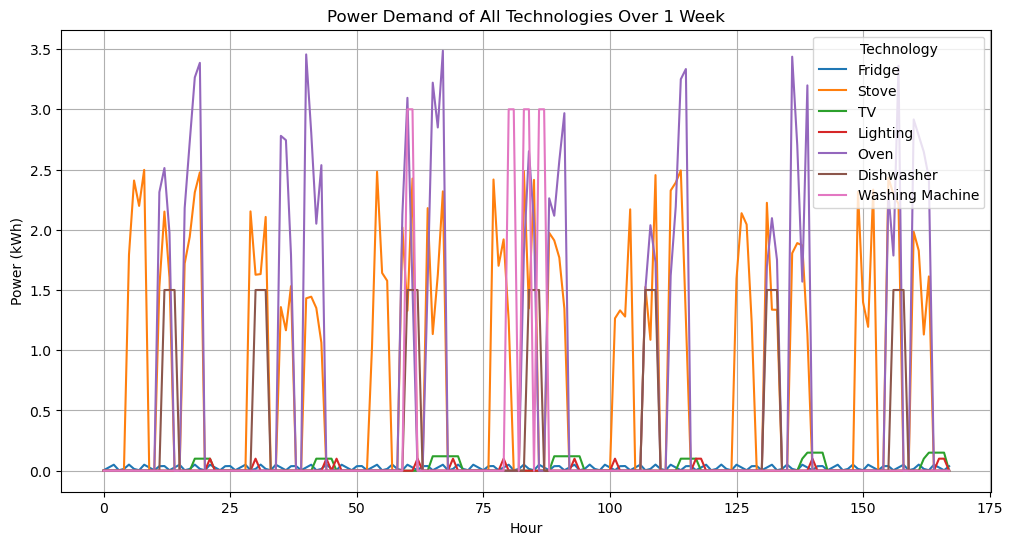

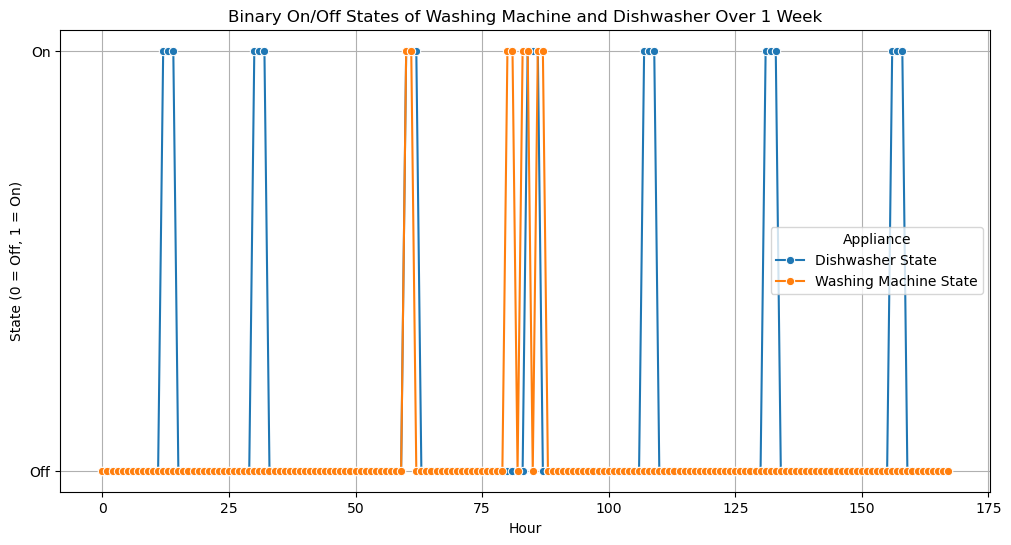

In [126]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Define the time range for one week
time_range = range(0, 24 * 7)  # 7 days, 24 hours each

# Create a DataFrame for the first plot
data_power = pd.DataFrame({
    'Hour': list(time_range),
    'Fridge': fridge[:len(time_range)],
    'Stove': stove[:len(time_range)],
    'TV': tv[:len(time_range)],
    'Lighting': lighting[:len(time_range)],
    'Oven': oven[:len(time_range)],
    'Dishwasher': [power_dishwasher * binary_dishwasher[t].X for t in time_range],
    'Washing Machine': [power_wm * binary_wm[t].X for t in time_range]
})

# Melt the data for easier plotting
data_power_melted = data_power.melt(id_vars='Hour', var_name='Technology', value_name='Power (kWh)')

# Plot 1: Power demand of all technologies
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_power_melted, x='Hour', y='Power (kWh)', hue='Technology')
plt.title('Power Demand of All Technologies Over 1 Week')
plt.xlabel('Hour')
plt.ylabel('Power (kWh)')
plt.legend(title='Technology')
plt.grid(True)
plt.show()

# Create a DataFrame for the second plot
data_binary = pd.DataFrame({
    'Hour': list(time_range),
    'Dishwasher State': [binary_dishwasher[t].X for t in time_range],
    'Washing Machine State': [binary_wm[t].X for t in time_range]
})

# Melt the data for easier plotting
data_binary_melted = data_binary.melt(id_vars='Hour', var_name='Appliance', value_name='State')

# Plot 2: Binary on/off states of washing machine and dishwasher
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_binary_melted, x='Hour', y='State', hue='Appliance', marker='o')
plt.title('Binary On/Off States of Washing Machine and Dishwasher Over 1 Week')
plt.xlabel('Hour')
plt.ylabel('State (0 = Off, 1 = On)')
plt.yticks([0, 1], ['Off', 'On'])
plt.legend(title='Appliance')
plt.grid(True)
plt.show()
